In [1]:
%load_ext autoreload
%autoreload 2

from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

from datetime import timedelta, date
import time
import os

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats
from mechafil.power import forecast_power_stats, build_full_power_stats_df, scalar_or_vector_to_vector
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects


In [2]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)
n_jobs = 4

os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

current_date = datetime.datetime.today().date() - timedelta(days=1)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2023, 1, 1)
start_day = (start_date - datetime.date(2020, 10, 15)).days

forecast_lenght = 365 * 9
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

2023-01-01
2023-02-08
2032-02-06


In [12]:
# baseline crossing plots
def plt_network_metrics(df_summaries_by_dur,
                        quantity_to_plot='day_pledge_per_QAP', 
                        scale_by=EIB, 
                        sup_title_str='',
                        smooth_by=1,
                        save_fp=None):
    # define plot settings and palette
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (18,18)
    
    colors_ = [
        mpl.colormaps['Purples'],
        mpl.colormaps['Blues'],
        mpl.colormaps['Greens'],
        mpl.colormaps['Oranges'],
        mpl.colormaps['Reds']
    ]
    cmap_select_flt = 0.5
    linestyles = ['-', '--', ':', '-.']
    duration_slp_coloridx_vec = np.linspace(0,1,len(duration_slp_vec))
    fig, axs = plt.subplots(4,2, constrained_layout=True)
    rolling_fn = lambda x: np.nanmedian(x)
    
    duration_slp_vec_itr = reversed(duration_slp_vec_plt)
    for ii, duration_slp in enumerate(duration_slp_vec_itr):
        duration_slp_coloridx = duration_slp_coloridx_vec[ii]
        plt_linestyle = linestyles[ii]
        for jj, sector_duration_yr in enumerate(sector_durations_yr_plt):
            cmap = colors_[jj]
            key = (sector_duration_yr, duration_slp)
            cil_df_summary = df_summaries_by_dur[key]
            cil_df_summary = cil_df_summary[cil_df_summary['date'] <= pd.to_datetime(date(2029, 1, 1))]

            # select plotting data
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_RBP'] / scale_by
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_RBP'] / scale_by
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_RBP'] / scale_by
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_RBP'] / scale_by
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_RBP'] / scale_by
            # plot RBP predictions
#             axs[0,0].fill_between(dates_, q5_t.rolling(smooth_by).apply(rolling_fn), q95_t.rolling(smooth_by).apply(rolling_fn), 
#                              alpha=0.5, color=colors_[c_idx][0], label='RBP Q90')
#             axs[0,0].fill_between(dates_, q25_t.rolling(smooth_by).apply(rolling_fn), q75_t.rolling(smooth_by).apply(rolling_fn), 
#                              alpha=0.65, color=colors_[c_idx][1], label='RBP Q50')
            axs[0,0].plot(dates_, q50_t.rolling(smooth_by).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
              # TODO: add this in
        #     # plot baseline
        #     axs[0,0].plot(dates_, baseline[0:len(dates_)], c='darkblue', label='baseline target')  
        #     axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            axs[0,0].tick_params(axis='x', labelrotation = 30)
            axs[0,0].set_title('Network RBP')
            axs[0,0].set_ylabel('EiB')

            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_QAP'] / scale_by
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_QAP'] / scale_by
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_QAP'] / scale_by
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_QAP'] / scale_by
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_QAP'] / scale_by
            # plot QAP predictions
    #         axs[0,1].fill_between(dates_, q5_t.rolling(smooth_by).apply(rolling_fn), q95_t.rolling(smooth_by).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='QAP Q90')
    #         axs[0,1].fill_between(dates_, q25_t.rolling(smooth_by).apply(rolling_fn), q75_t.rolling(smooth_by).apply(rolling_fn), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='QAP Q50')
            axs[0,1].plot(dates_, q50_t.rolling(smooth_by).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
              # TODO: add this in
        #     # plot baseline
        #     axs[0,0].plot(dates_, baseline[0:len(dates_)], c='darkblue', label='baseline target')  
        #     axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            axs[0,1].tick_params(axis='x', labelrotation = 30)
            axs[0,1].set_title('Network QAP')
            axs[0,1].set_ylabel('EiB')

            # plot pledge per sector
            w = 7
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_pledge_per_QAP'] 
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_pledge_per_QAP']
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_pledge_per_QAP']
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_pledge_per_QAP']
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_pledge_per_QAP']
#             axs[1,0].fill_between(dates_, q05_t.rolling(w).apply(rolling_fn), q95_t.rolling(w).apply(rolling_fn), 
#                              alpha=0.5, color=colors_[c_idx][0])
#             axs[1,0].fill_between(dates_, q25_t.rolling(w).apply(rolling_fn), q75_t.rolling(w).apply(rolling_fn), 
#                              alpha=0.65, color=colors_[c_idx][1])
            axs[1,0].plot(dates_, q50_t.rolling(w).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, label='%dY-%0.02f' % (sector_duration_yr,duration_slp), linestyle=plt_linestyle)
            axs[1,0].tick_params(axis='x', labelrotation = 30)
            axs[1,0].set_title('Pledge per 32 GiB')
            axs[1,0].legend(ncol=2)
            axs[1,0].set_ylabel('FIL')
            axs[1,0].set_ylim(0,0.5)

            # plot network reward
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_network_reward'] 
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_network_reward'] 
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_network_reward'] 
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_network_reward']
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_network_reward']
    #         axs[1,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='Q5-Q95')
    #         axs[1,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='Q25-Q75')
            axs[1,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
            axs[1,1].tick_params(axis='x', labelrotation = 30)
            axs[1,1].set_title('Minting')
    #         axs[1,1].legend(loc='upper right')
            axs[1,1].set_ylabel('FIL/day')

            # plot roi
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['1y_sector_roi'] * 100
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['1y_sector_roi']  * 100
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['1y_sector_roi'] * 100
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['1y_sector_roi'] * 100
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['1y_sector_roi'] * 100
    #         axs[2,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='Q5-Q95')
    #         axs[2,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='Q25-Q75')
            axs[2,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
            axs[2,1].tick_params(axis='x', labelrotation = 30)
            axs[2,1].set_title('1y sector ROI')
    #         axs[2,1].legend(loc='upper left')
            axs[2,1].set_ylabel('%')
            axs[2,1].set_ylim(0,100)
            xt = axs[2,1].get_xticks()
            xl = axs[2,1].get_xlim()

            # plot daily locked pledge
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_locked_pledge'] 
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_locked_pledge'] 
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_locked_pledge'] 
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_locked_pledge']
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_locked_pledge']
    #         axs[2,0].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='Q5-Q95')
    #         axs[2,0].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).median(), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='Q25-Q75')
            axs[2,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
            axs[2,0].tick_params(axis='x', labelrotation = 30)
            axs[2,0].set_title('Daily locked pledge')
    #         axs[2,0].legend(loc='upper right')
            axs[2,0].set_ylabel('FIL/day')
            axs[2,0].set_yscale('log')

            # plot network locked
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_locked'] / 1e6
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_locked'] / 1e6 
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_locked'] / 1e6 
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_locked'] / 1e6
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_locked'] / 1e6
    #         axs[3,0].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='Q5-Q95')
    #         axs[3,0].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='Q25-Q75')
            axs[3,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
            axs[3,0].tick_params(axis='x', labelrotation = 30)
            axs[3,0].set_title('Network locked')
    #         axs[3,0].legend(loc='upper right')
            axs[3,0].set_ylabel('M-FIL')

            # plot lock / supply
            cil_df_summary['locked_over_supply'] = cil_df_summary['network_locked'] / cil_df_summary['circ_supply']
            dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
            q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['locked_over_supply'] * 100
            q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['locked_over_supply'] * 100
            q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['locked_over_supply'] * 100
            q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['locked_over_supply'] * 100
            q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['locked_over_supply'] * 100
    #         axs[3,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.5, color=colors_[c_idx][0], label='Q5-Q95')
    #         axs[3,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
    #                          alpha=0.65, color=colors_[c_idx][1], label='Q25-Q75')
            axs[3,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), 
                          color=cmap(cmap_select_flt), lw=2, linestyle=plt_linestyle)
            axs[3,1].tick_params(axis='x', labelrotation = 30)
            axs[3,1].set_title('Locked / Supply')
    #         axs[3,1].legend(loc='upper right')
            axs[3,1].set_ylabel('%')
#             axs[3,1].set_ylim(0,50)

#     plt.suptitle(sup_title_str)
    plt.tight_layout()
#     plt.show()
    
    if save_fp is not None:
        plt.savefig(save_fp)

In [4]:
# simulation
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

qap_mode = 'basic-sdm'
all_sector_no_jump_config = {
    'type': 'noop',
    'num_days_shock_behavior': 360,
    'intervention_date': datetime.date(2023,3,15),
    'simulation_start_date': current_date + datetime.timedelta(days=1),
    'sdm_onboard_before_intervention': False,
    'sdm_onboard_after_intervention': True,
    'sdm_renew_before_intervention': False,
    'sdm_renew_after_intervention': True
}

# seperating from the expensive MCMC loop
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
    return df_out

def run_sim(fil_plus_rate:Union[float, np.array], 
            rb_onboard_power:[float, np.array], 
            renewal_rate:[float, np.array],
            sector_duration:int,
            duration_m:callable)->pd.DataFrame():
    sector_duration = int(sector_duration)
    future_renewal_rate = scalar_or_vector_to_vector(renewal_rate, forecast_lenght)
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        future_renewal_rate,
        fil_plus_rate,
        sector_duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=all_sector_no_jump_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )

    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        sector_duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec,
        fil_plus_rate=fil_plus_rate,
        intervention_config=all_sector_no_jump_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    return cil_df

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

def run_one_mc(i, fil_plus_rate, rb_onboard_power, renewal_rate, sector_duration_days, duration_multipler_fn):
    cil_df_i = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate, sector_duration_days, duration_multipler_fn)
    cil_df_i['iter'] = i
        
    return cil_df_i

def run_sim_mc(fpr_preds, rbp_preds, rr_preds, sector_duration_days, duration_multiplier_callable)->pd.DataFrame:
    idxs = range(len(fpr_preds))
    results = Parallel(n_jobs=n_jobs)(delayed(run_one_mc)(i, 
                                                          fpr_preds[i,:], 
                                                          rbp_preds[i,:], 
                                                          rr_preds[i,:],
                                                          sector_duration_days,
                                                          duration_multiplier_callable
                                                         ) for i in tqdm(idxs))
    cil_df = pd.concat(results, ignore_index=True)
    cil_df['sector_duration_yr'] = int(sector_duration_days/365)
    cil_df.index = cil_df.date
    cil_df.drop('date', axis=1, inplace=True)
    return cil_df

# baseline storage function
def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# summary statistics of trajectory dynamics
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    roi_duration = 365 # for computing 1Y ROI
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df[['iter','day_rewards_per_sector']].groupby('iter').rolling(roi_duration).sum().shift(-roi_duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

In [5]:
# separate expensive preprocessing from MCMC loop
rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
vest_df = compute_vesting_trajectory_df(start_date, end_date)
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
t_historical_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)
t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)

In [6]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = current_date - datetime.timedelta(days=mcmc_train_len_days)
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
# num_warmup_mcmc = 5000
# num_samples_mcmc = 500
num_warmup_mcmc = 500
num_samples_mcmc = 25
seasonality_mcmc = 3000
num_chains_mcmc = 2

rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
    generate_mcmc_forecast_samples(mcmc_train_start_date,
                                   mcmc_train_end_date,
                                   forecast_lenght,
                                   num_warmup_mcmc,
                                   num_samples_mcmc,
                                   seasonality_mcmc,
                                   num_chains_mcmc)

Forecasting Onboarding Power


  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.06      0.05     -0.05     -0.17     -0.00     35.35      1.05
       init_s[0]     -4.22     31.05      0.04    -70.05     44.97     10.04      1.39
       init_s[1]      0.10      0.28      0.08     -0.31      0.54    186.26      0.97
       init_s[2]     -0.98      0.34     -0.99     -1.61     -0.58     93.23      0.99
       init_s[3]     -0.89      0.42     -0.87     -1.62     -0.29    124.59      0.97
       init_s[4]     -0.76      0.51     -0.70     -1.43      0.31     64.65      0.96
       init_s[5]     -0.32      0.49     -0.28     -1.12      0.48     36.74      0.99
       init_s[6]     -0.45      0.52     -0.45     -1.27      0.25     18.82      1.03
       init_s[7]     -0.74      0.45     -0.67     -1.33      0.08     21.36      1.00
       init_s[8]      0.09      0.52      0.11     -0.81      0.82     32.20      1.00
       init_s[9]     -0.70      0.56     -

Forecasting Renewal Rate


  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      4.83      4.33      2.47      0.71     12.61      2.60      2.67
       init_s[0]     -9.99     22.75     -3.33    -37.43     19.66     13.79      1.17
       init_s[1]     12.68      2.16     13.19      8.76     14.90      1.20      2.96
       init_s[2]     -1.56      1.98     -2.07     -4.47      1.42      1.28      2.17
       init_s[3]     -3.34      1.93     -4.20     -5.83     -1.16      1.29      2.08
       init_s[4]     94.25      1.70     94.29     91.80     96.32      1.34      2.19
       init_s[5]      1.12      1.88      0.88     -1.45      4.34      1.48      1.75
       init_s[6]      2.30      1.58      2.63      0.32      4.63      1.23      2.35
       init_s[7]     -0.09      1.77     -0.64     -2.44      2.31      1.43      1.92
       init_s[8]     -0.04      1.57     -0.23     -2.31      2.05      1.23      2.52
       init_s[9]     -0.22      1.54     -

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.32      0.36      0.21      0.00      0.82     10.83      1.19
       init_s[0]    -32.77     39.93    -12.96    -80.59     11.44      1.36      2.18
       init_s[1]      0.57      0.60      0.35     -0.07      1.65      6.80      1.08
       init_s[2]      0.66      0.64      0.83     -0.46      1.54     34.22      1.00
       init_s[3]      1.01      0.87      0.95     -0.59      2.24     63.67      0.97
       init_s[4]     14.70      1.20     14.67     13.06     16.17      2.94      1.49
       init_s[5]     -0.69      0.69     -0.43     -1.85      0.46      5.87      1.12
       init_s[6]     -0.33      0.89     -0.68     -1.06      1.27     34.26      1.01
       init_s[7]     -0.68      0.73     -1.04     -1.51      0.66      5.39      1.13
       init_s[8]     -1.05      0.85     -1.24     -2.06      0.85     40.33      0.97
       init_s[9]     -1.04      0.88     -

Forecasting FIL+ Rate


  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.04      0.06      0.02     -0.01      0.15      2.53      2.05
       init_s[0]     -0.06      0.17     -0.09     -0.35      0.17     63.06      1.01
       init_s[1]      0.19      0.35      0.32     -0.29      0.53      1.11      4.36
       init_s[2]      0.53      0.77      0.66     -0.37      1.31      1.07      9.22
       init_s[3]      0.01      0.38      0.09     -0.58      0.44      1.21      2.86
       init_s[4]     -0.19      0.19     -0.09     -0.53      0.02      1.82      1.50
       init_s[5]      0.36      0.49      0.20     -0.28      0.97      1.17      3.53
       init_s[6]     -0.08      0.35     -0.27     -0.41      0.41      1.15      3.36
       init_s[7]      0.10      0.15      0.18     -0.20      0.27      2.01      1.49
       init_s[8]      0.65      0.61      0.78     -0.05      1.26      1.09      5.55
       init_s[9]     -0.14      0.33     -

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.03      0.02     -0.03     -0.06     -0.00     21.57      1.07
       init_s[0]     -2.97     46.18      0.30   -102.84     53.99     35.14      0.99
       init_s[1]      0.34      0.31      0.37     -0.10      0.84     59.93      1.01
       init_s[2]     -0.66      0.31     -0.66     -1.08     -0.11     64.61      0.99
       init_s[3]     -0.32      0.42     -0.33     -0.93      0.29     25.10      1.00
       init_s[4]     -0.21      0.51     -0.13     -1.01      0.48     57.71      0.98
       init_s[5]      0.03      0.41      0.02     -0.65      0.53    107.73      0.98
       init_s[6]     -0.53      0.49     -0.47     -1.29      0.33     66.24      1.00
       init_s[7]     -0.63      0.57     -0.67     -1.36      0.22     46.45      1.01
       init_s[8]      0.11      0.64      0.12     -0.77      1.23     43.71      1.00
       init_s[9]     -0.85      0.62     -

In [17]:
def duration_master_fn(d, slope=1, clip=None):
    if d < round(365*1.5):
        return 1
    else:
        y1_slp1 = 1
        y2_slp1 = 2 - 183/365.
        x1_slp1 = round(365*1.5)
        x2_slp1 = 365*2
        m = (y2_slp1 - y1_slp1) / (x2_slp1 - x1_slp1)
        m *= slope
        # y-y1 = m*(x-x1)
        y = m*(d - x1_slp1) + y1_slp1
        if clip is not None:
            if y > clip:
                y = clip
        return y
    
# define duration multiplier callables - we need to redefine these callables to be compatible w/ mechaFIL
def no_sdm(d):
    return 1

def duration_m_slp_1(d):
    return duration_master_fn(d, slope=1, clip=sdm_clip)

def duration_m_slp_0_1(d):
    return duration_master_fn(d, slope=0.1, clip=sdm_clip)

def duration_m_slp_0_15(d):
    return duration_master_fn(d, slope=0.15, clip=sdm_clip)

def duration_m_slp_0_2(d):
    return duration_master_fn(d, slope=0.2, clip=sdm_clip)

def duration_m_slp_0_25(d):
    return duration_master_fn(d, slope=0.25, clip=sdm_clip)

def duration_m_slp_0_3(d):
    return duration_master_fn(d, slope=0.3, clip=sdm_clip)


duration2callable = {
    0: no_sdm,
    1: duration_m_slp_1,
    0.1: duration_m_slp_0_1,
    0.15: duration_m_slp_0_15,
    0.2: duration_m_slp_0_2,
    0.25: duration_m_slp_0_25,
    0.3: duration_m_slp_0_3,
}

In [18]:
num_mcmc_samps = filplus_rate_pred.shape[0]
fpr_config = 'mcmc'  # can be 'mcmc', '100', or '25'
rr_config = 'mcmc'   # can be 'mcmc', 'lasthistorical'
rbp_config = 'mcmc'  # can be 'mcmc', 'lasthistorical'

# scaling config
scale_rbp_by_sdm = False
scale_rr_by_sdm = False
sdm_clip = 3.5

if fpr_config != 'mcmc' and rr_config != 'mcmc' and rbp_config != 'mcmc':
    num_mcmc_samps = 1  # no variation so no need to run multiple sims, it is deterministic

#duration_slp_vec = [0, 0.1, 0.2, 0.3, 1]
duration_slp_vec = [0, 0.3, 1]
sector_durations_yr = [1,3,5]  # sector duration simulations
input_quantiles_by_duration_slp = {}
inputs_by_duration_slp = {}
for duration_slp in duration_slp_vec:
    duration_m = duration2callable[duration_slp]
    
    for sector_duration_yr in sector_durations_yr:
        rbp_in = []
        rr_in = []
        fpr_in = []
        for i in range(num_mcmc_samps):
            sector_duration = sector_duration_yr * 365
            qap_scale_factor = duration_m(sector_duration)

            if rbp_config == 'mcmc':
                rbp_forecast = np.asarray(rb_onboard_power_pred[i,:])
            elif rbp_config == 'lasthistorical':
                rbp_forecast = np.ones(forecast_lenght) * historical_rbp[-1]
            else:
                raise ValueError("unsupported RBP config!")

            if rr_config == 'mcmc':
                rr_forecast = np.asarray(renewal_rate_pred[i,:])
            elif rr_config == 'lasthistorical':
                rr_forecast = np.ones(forecast_lenght) * historical_renewal_rate[-1]
            else:
                raise ValueError('Unsupported RR Config!')

            if fpr_config == 'mcmc':
                fpr_forecast = np.asarray(filplus_rate_pred[i,:])
            elif fpr_config == '100':
                fpr_forecast = np.ones(forecast_lenght) * 1  # all onboards are FIL+
            elif fpr_config == '25':
                fpr_forecast = np.ones(forecast_lenght) * 0.25  # all onboards are FIL+
            else:
                raise ValueError("Unsupported FPR Config!")

            if scale_rbp_by_sdm:
                rbp_forecast /= qap_scale_factor
            if scale_rr_by_sdm:
                rr_forecast /= qap_scale_factor

            rbp_in.append(rbp_forecast)
            rr_in.append(rr_forecast)
            fpr_in.append(fpr_forecast)

        rbp_in = np.asarray(rbp_in)
        rr_in = np.asarray(rr_in)
        fpr_in = np.asarray(fpr_in)

        rbp_Q = np.quantile(rbp_in, [0.05,0.25,0.5,0.75,0.95], axis=0)
        rr_Q = np.quantile(rr_in, [0.05,0.25,0.5,0.75,0.95], axis=0)
        fpr_Q = np.quantile(fpr_in, [0.05,0.25,0.5,0.75,0.95], axis=0)

        inputs_df = pd.DataFrame()
        inputs_df['rbp_Q05'] = rbp_Q[0,:]
        inputs_df['rbp_Q25'] = rbp_Q[1,:]
        inputs_df['rbp_Q50'] = rbp_Q[2,:]
        inputs_df['rbp_Q75'] = rbp_Q[3,:]
        inputs_df['rbp_Q95'] = rbp_Q[4,:]

        inputs_df['rr_Q05'] = rr_Q[0,:]
        inputs_df['rr_Q25'] = rr_Q[1,:]
        inputs_df['rr_Q50'] = rr_Q[2,:]
        inputs_df['rr_Q75'] = rr_Q[3,:]
        inputs_df['rr_Q95'] = rr_Q[4,:]

        inputs_df['fpr_Q05'] = fpr_Q[0,:]
        inputs_df['fpr_Q25'] = fpr_Q[1,:]
        inputs_df['fpr_Q50'] = fpr_Q[2,:]
        inputs_df['fpr_Q75'] = fpr_Q[3,:]
        inputs_df['fpr_Q95'] = fpr_Q[4,:]

        key = (sector_duration_yr, duration_slp)
        input_quantiles_by_duration_slp[key] = inputs_df
        inputs_by_duration_slp[key] = {
            'rbp_in': rbp_in,
            'rr_in': rr_in,
            'fpr_in': fpr_in
        }

In [19]:
cil_df_by_dur = {}
for duration_slp in duration_slp_vec:
    for dur in sector_durations_yr:
        key = (dur, duration_slp)

        sdm_fn = duration2callable[duration_slp]
        input_dict = inputs_by_duration_slp[key]
        df = run_sim_mc(input_dict['fpr_in'], input_dict['rbp_in'], input_dict['rr_in'], dur*365, sdm_fn)
        
        cil_df_by_dur[key] = df

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
# add ROI & summary
df_summaries_dict = {}

duration_slp_vec_plt = [0, 0.3, 1]
sector_durations_yr_plt = [1,3,5]

for duration_slp in duration_slp_vec_plt:
    for sector_duration_yr in sector_durations_yr_plt:
        key = (sector_duration_yr, duration_slp)
        
        cil_mcmc_df_yr = cil_df_by_dur[key]
        cil_mcmc_df_roi_yr = add_generated_quantities(cil_mcmc_df_yr)
        cil_mcmc_df_summary_yr = get_df_summary(cil_mcmc_df_roi_yr)

        df_summaries_dict[key] = cil_mcmc_df_summary_yr

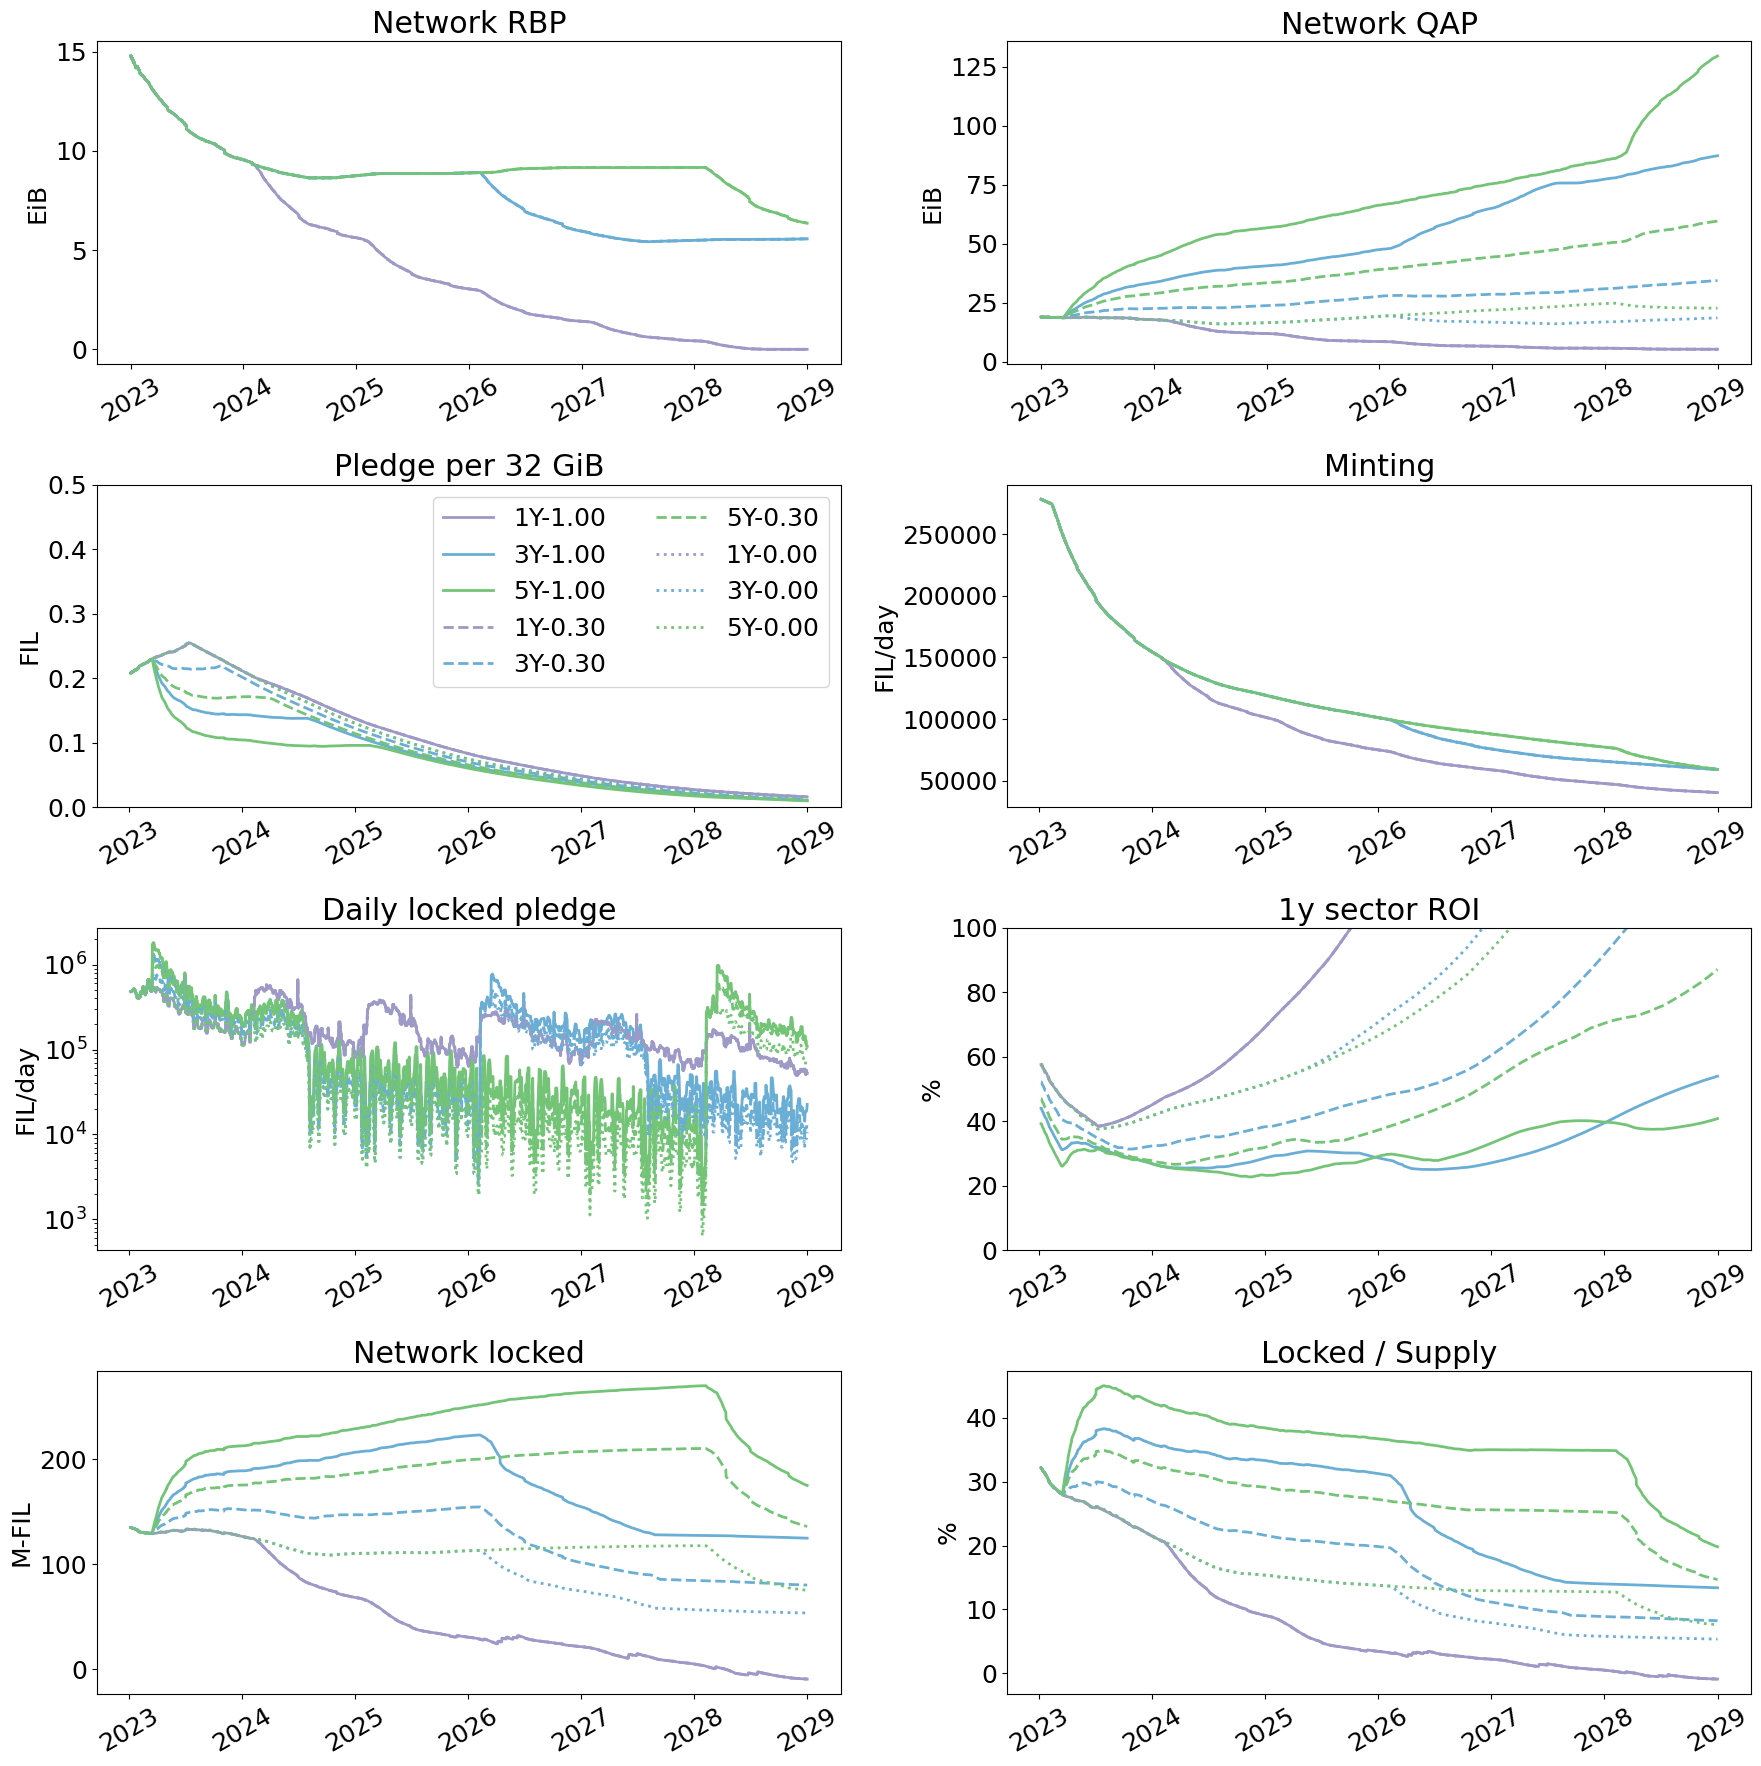

In [21]:
save_folder = '/Users/kiran/Documents/hackmd/sdm_slopes/'
if sdm_clip is not None:
    save_fp = 'rbp-%s-%s_rr-%s-%s_fpr-%s-sdmclip-%0.02f.png' % \
        (rbp_config,scale_rbp_by_sdm,rr_config,scale_rr_by_sdm,fpr_config, sdm_clip)
else:
    save_fp = 'rbp-%s-%s_rr-%s-%s_fpr-%s.png' % \
        (rbp_config,scale_rbp_by_sdm,rr_config,scale_rr_by_sdm,fpr_config)

plt_network_metrics(df_summaries_dict, 
                    quantity_to_plot='network_RBP', 
                    scale_by=EIB,
                    sup_title_str='',
                    save_fp=os.path.join(save_folder, save_fp))

In [ ]:
# plot the inputs
plt.figure(figsize=(8,5))
colors_ = [['peachpuff', 'tan', 'peru'], 
           ['powderblue', 'skyblue', 'steelblue'], 
           ['lightsalmon', 'tomato', 'firebrick']]
plt_max = date(2029, 1, 1)
num_days_plot = (plt_max - start_date).days
t = [start_date + datetime.timedelta(days=i) for i in range(num_days_plot)]
plt.rcParams.update({'font.size': 10})

plt.subplot(2,2,1)
for c_idx, sector_duration_yr in enumerate(sector_durations_yr):
    inputs_df = input_quantiles_by_duration[sector_duration_yr]
    plt.fill_between(t, inputs_df['rbp_Q05'].values[0:num_days_plot], inputs_df['rbp_Q95'].values[0:num_days_plot], 
                     alpha=0.65, color=colors_[c_idx][0])
    plt.fill_between(t, inputs_df['rbp_Q25'].values[0:num_days_plot], inputs_df['rbp_Q75'].values[0:num_days_plot], 
                     alpha=0.65, color=colors_[c_idx][1])
    plt.plot(t, inputs_df['rbp_Q50'].values[0:num_days_plot], alpha=1, color=colors_[c_idx][2], lw=2, label='%dY' % (sector_duration_yr,))
plt.tick_params(axis='x', labelrotation = 60)
plt.title('RBP Onboarded')
plt.ylabel('PiB/day')
plt.legend()    
    
plt.subplot(2,2,2)
for c_idx, sector_duration_yr in enumerate(sector_durations_yr):
    inputs_df = input_quantiles_by_duration[sector_duration_yr]
    plt.fill_between(t, inputs_df['rr_Q05'].values[0:num_days_plot]*100, inputs_df['rr_Q95'].values[0:num_days_plot]*100, 
                     alpha=0.65, color=colors_[c_idx][0])
    plt.fill_between(t, inputs_df['rr_Q25'].values[0:num_days_plot]*100, inputs_df['rr_Q75'].values[0:num_days_plot]*100, 
                     alpha=0.65, color=colors_[c_idx][1])
    plt.plot(t, inputs_df['rr_Q50'].values[0:num_days_plot]*100, alpha=1, color=colors_[c_idx][2], lw=2, label='%dY' % (sector_duration_yr,))
    plt.tick_params(axis='x', labelrotation = 60)
    
plt.tick_params(axis='x', labelrotation = 60)
plt.title('Renewal Rate')
plt.ylabel('%')

plt.subplot(2,2,3)
plt.plot(t, inputs_df['fpr_Q50'].values[0:num_days_plot]*100, alpha=1, lw=2)
plt.tick_params(axis='x', labelrotation = 60)
plt.title('FIL+ Rate')
plt.ylabel('%')

plt.subplot(2,2,4)
slp_1 = np.zeros(len(days))
slp_0_1 = np.zeros(len(days))
slp_0_2 = np.zeros(len(days))
slp_0_3 = np.zeros(len(days))
clip = 3.5
days = np.arange(0,365*5)
for d in days:
    slp_1[d] = duration_m_slp_0_2(d)
    slp_0_1[d] = duration_m_slp_0_1(d)
    slp_0_2[d] = duration_m_slp_0_2(d)
    slp_0_3[d] = duration_m_slp_0_3(d)
plt.figure()
plt.plot(days/365., slp_1, label='Slope=1')
plt.plot(days/365., slp_0_1, label='Slope=0.1')
plt.plot(days/365., slp_0_3, label='Slope=0.2')
plt.plot(days/365., slp_0_3, label='Slope=0.3')
plt.legend()
    
plt.tight_layout()

if sdm_clip is not None:
    save_fp = 'inputs-rbp-%s-%s_rr-%s-%s_fpr-%s-sdmclip-%0.02f.png' % \
        (rbp_config,scale_rbp_by_sdm,rr_config,scale_rr_by_sdm,fpr_config, sdm_clip)
else:
    save_fp = 'inputs-rbp-%s-%s_rr-%s-%s_fpr-%s.png' % \
        (rbp_config,scale_rbp_by_sdm,rr_config,scale_rr_by_sdm,fpr_config)
    
plt.savefig(os.path.join(save_folder, save_fp))